### 使用对数几率回归：预测西瓜好坏

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # (屏蔽UserWarning)

In [3]:
# 加载数据集
data_path = '../temp/data_melon.xlsx'
data = pd.read_excel(data_path)
data  # (DataFrame)

,密度,含糖率,好瓜
0,0.697,0.460,1
1,0.774,0.376,1
2,0.634,0.264,1
3,0.608,0.318,1
4,0.556,0.215,1
5,0.403,0.237,1
6,0.657,0.198,0
7,0.360,0.370,0
8,0.666,0.091,0
9,0.243,0.267,0


In [4]:
# 特征和标签
X_origin = data[['密度', '含糖率']].values  # 特征 (numpy.ndarray) 
y = data['好瓜'].values  # 输出标签，是否为好瓜 (numpy.ndarray) 

# 归一化（对数几率回归通常需要对输入进行标准化）
scaler = StandardScaler()
X = scaler.fit_transform(X_origin)

# ndarray → tensor
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # 转换为列向量

In [5]:
# 自定义对数几率回归模型
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        # 使用sigmoid激活
        return torch.sigmoid(self.linear(x))

In [6]:
LR = 0.01
EPOCHS = 1000

model = LogisticRegressionModel()
criterion = nn.BCELoss()  # 使用二元交叉熵度量损失
optimizer = optim.SGD(model.parameters(), lr=LR)  # 使用SGD优化

In [7]:
# train (数据量较小,故epoch内不再分batch)
for epoch in range(EPOCHS):
    # 前向传播 
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 只打印10个loss
    if (epoch + 1) % (EPOCHS // 10) == 0:
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.5890
Epoch [200/1000], Loss: 0.5490
Epoch [300/1000], Loss: 0.5238
Epoch [400/1000], Loss: 0.5070
Epoch [500/1000], Loss: 0.4953
Epoch [600/1000], Loss: 0.4869
Epoch [700/1000], Loss: 0.4806
Epoch [800/1000], Loss: 0.4758
Epoch [900/1000], Loss: 0.4721
Epoch [1000/1000], Loss: 0.4691


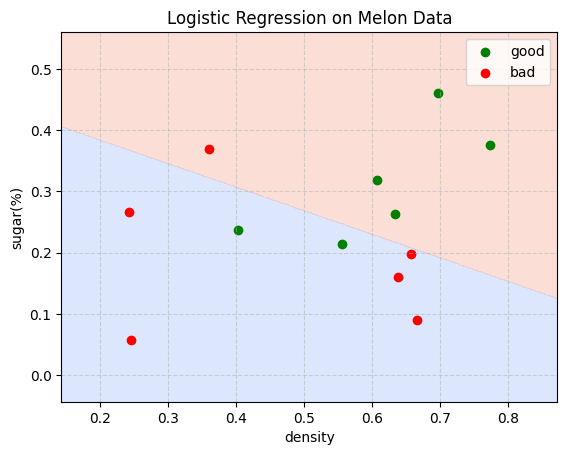

In [8]:
# 绘制原始数据集的散点图 (未归一化数据)
def plot_original_data(X, y, scaler):
    # 逆标准化数据
    X_original = scaler.inverse_transform(X)

    # 好瓜(绿色点); 坏瓜(红色点)
    good_melon = X_original[y == 1]
    bad_melon = X_original[y == 0]
    plt.scatter(good_melon[:, 0], good_melon[:, 1], color='green', label='good', marker='o')
    plt.scatter(bad_melon[:, 0], bad_melon[:, 1], color='red', label='bad', marker='o')

    plt.xlabel('density')
    plt.ylabel('sugar(%)')
    plt.legend()
    plt.title('Logistic Regression on Melon Data')

    plt.grid(True, linestyle='--', alpha=0.5)  # 启用网格线，虚线样式，透明度0.5

    plt.show()


# 绘制决策边界 (未归一化数据)
def plot_decision_boundary_original_scale(model, X, y, scaler):
    # 逆标准化数据
    X_original = scaler.inverse_transform(X)

    x_min, x_max = X_original[:, 0].min() - 0.1, X_original[:, 0].max() + 0.1
    y_min, y_max = X_original[:, 1].min() - 0.1, X_original[:, 1].max() + 0.1

    # 创建密集网格点 (原始尺度下)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001), np.arange(y_min, y_max, 0.001))
    grid_original = np.c_[xx.ravel(), yy.ravel()]

    # 将网格点标准化以输入模型
    grid_standardized = scaler.transform(grid_original)
    grid_standardized = torch.tensor(grid_standardized, dtype=torch.float32)

    # 通过模型预测网格点的分类
    with torch.no_grad():
        Z = model(grid_standardized).reshape(xx.shape)
        Z = (Z >= 0.5).float().numpy()

    # 决策边界
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap='coolwarm', alpha=0.3)

    # 添加网格线
    plt.grid(True, linestyle='--', alpha=0.5)  # 启用网格线，虚线样式，透明度0.5

    # 最后统一绘制 (调用原始数据点的绘制函数)
    plot_original_data(X, y, scaler)


# 绘制决策边界（使用未归一化数据）
plot_decision_boundary_original_scale(model, X_train.numpy(), y, scaler)


In [9]:
# 查看输出模型参数 & 评估准确率
with torch.no_grad():
    predictions = model(X_train)
    predicted = (predictions >= 0.5).float()
    accuracy = (predicted.eq(y_train).sum() / y_train.shape[0]).item()
    print(f'weight: {model.linear.weight.data}')
    print(f'bias: {model.linear.bias.data}')
    print(f'Accuracy: {accuracy * 100:.2f}%')

weight: tensor([[0.6924, 1.1814]])
bias: tensor([-0.0280])
Accuracy: 75.00%
